In [105]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import math
from sklearn.model_selection import KFold
# from sklearn.metrics import RocCurveDisplay, auc
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.gridspec as gridspec

In [ ]:
# dataset structure: emotion subject arousal valence features
sd_dataset=np.loadtxt('subject_dependent_set.txt')
sid_dataset=np.loadtxt('subject_independent_dataset.txt')

In [65]:
def ROC_curve_calculator(Y, prob, meanfpr):
    tprs=[]
    aucs=[]
    lb_binarizer = LabelBinarizer().fit(Y)
    # Y_onehot -> onehot code, 1 -> 1, 0, 0, 0
    Y_onehot = lb_binarizer.transform(Y)
    # calculation 4 all classes
    for i in range(4):
        # calculation 4 fpr, tpr, auc
        fpr, tpr,_ = metrics.roc_curve(Y_onehot[:, i], prob[:, i], pos_label=1)
        auc = metrics.roc_auc_score(Y_onehot[:, i], prob[:, i])
        # print(fpr, tpr)
        # linear interp
        interp_tpr = np.interp(meanfpr, fpr, tpr)
        interp_tpr[0] = 0.0
        
        tprs.append(interp_tpr)
        aucs.append(auc)
    
    # print(tprs)
    # print(auc)
    return tprs, aucs

def ROC_curve_splitter(tprs, aucs, mean_fpr):
    # num -> all, num_tprs 
    num = len(aucs)
    num_tprs = len(tprs[1])
    num_aucs = int(num/4)

    # tprs for 1, 2, 3, 4
    # aucs for 1, 2, 3, 4 in every fold
    tprs_mean = np.zeros([4,  num_tprs])
    aucs_fold = np.zeros([4, num_aucs])

    for i in range(4):
        j = i
        for j in range(i, num+i, 4):
            tprs_mean[i, :] += tprs[j]
            aucs_fold[i, int(j/4)]=metrics.auc(mean_fpr, tprs[j])

    tprs_mean = tprs_mean/num_aucs
    tprs_mean[:, -1] = 1.0
    tprs_std = np.std(np.array(tprs), axis=0)

    # calculation 4 auc mean
    auc_mean = metrics.auc(mean_fpr, np.mean(tprs_mean,axis=0))
    auc_emotion = np.zeros([1,4])
    for k in range(4):
        auc_emotion[:,k]=metrics.auc(mean_fpr,tprs_mean[k, :])
    
    # auc_std 
    auc_std = np.std(aucs)
    auc_std_emotion = np.std(aucs_fold, axis=1)

    return tprs_mean, tprs_std, auc_mean, auc_emotion, auc_std, auc_std_emotion

In [95]:
# subject dependent classifer
def sd_emotion_classifer(fold, dataset, gamma, C):
    feature_count_sd = np.zeros([1,15])
    loo=KFold(fold)
    cm_sd = np.zeros([4,4])
    accuracy_sd = np.zeros([fold, 2])
    # For every subject accuracy, recall, f1
    accuracy_sd_sb = np.zeros([8, 1])
    sb_counter = np.zeros([8, 1])
    # sb_counter2 = np.zeros([8, 4])
    # 8 for subjects, 4 for emotions
    precision = np.zeros([fold, 4])
    recall = np.zeros([fold, 4])
    f1_score = np.zeros([fold, 4])
    # emotion=np.array([1, 2, 3, 4])

    i = 0
    tprs=[]
    aucs=[]
    for k, (train_index, test_index) in enumerate(loo.split(dataset)):
        X_train_sd = dataset[train_index, 4: 19]
        Y_train_sd = dataset[train_index, 0]
        Y_arousal = dataset[train_index, 2]
        Y_valence = dataset[train_index, 3]
        X_test_sd = dataset[test_index, 4: 19]
        Y_test_sd = dataset[test_index, 0]
        sb_index_sd = dataset[test_index, 1]

        # Normalization
        sc = StandardScaler()
        X_train_sd = sc.fit_transform(X_train_sd)
        X_test_sd = sc.transform(X_test_sd)
        
        # feature_selection
        # importance for valence
        model_v=SVC(kernel='rbf', gamma=gamma,C=C)
        model_v.fit(X_train_sd, Y_valence)
        result = permutation_importance(model_v, X_train_sd, Y_valence, scoring='accuracy',            n_repeats=200,random_state=42)
        importance_v = result.importances_mean
        # importance for arousal
        model_a=SVC(kernel='rbf', gamma=gamma,C=C)
        model_a.fit(X_train_sd, Y_arousal)
        result = permutation_importance(model_a, X_train_sd, Y_arousal, scoring='accuracy', n_repeats=200,random_state=42)
        # selection
        importance_a = result.importances_mean
        important_a_idx = np.argsort(importance_a)[::-1][:8]
        important_v_idx = np.argsort(importance_v)[::-1][:8]
        important_indices = np.unique(np.concatenate([important_a_idx, important_v_idx]))
        important_indices=important_indices[0:8]
        X_train_sd_selected = X_train_sd[:, important_indices]
        X_test_sd_selected = X_test_sd[:, important_indices]
        # count selected features
        feature_count=np.zeros([1, 15])
        feature_count[:, important_indices]=1
        feature_count_sd+=feature_count
  
        # rbf classifer
        rbf_sd = SVC(kernel='rbf', gamma=gamma, C=C, random_state=42, probability=True).fit(X_train_sd_selected, Y_train_sd.ravel())
        rbf_pred_train = rbf_sd.predict(X_train_sd_selected)
        rbf_pred_test = rbf_sd.predict(X_test_sd_selected)
        rbf_pred_prob = rbf_sd.predict_proba(X_test_sd_selected)
        # print(rbf_pred_prob)

        rbf_accuracy_train = accuracy_score(Y_train_sd, rbf_pred_train)
        rbf_accuracy_test = accuracy_score(Y_test_sd, rbf_pred_test)

        # Calculation 4 accuracy average&subject
        accuracy_sd[i, 0] = rbf_accuracy_train
        accuracy_sd[i, 1] = rbf_accuracy_test
        for j in range(8):
            if any(sb_index_sd==j+1):
                # accuracy
                accuracy_sd_sb[j, 0] += accuracy_score(Y_test_sd[sb_index_sd==j+1], rbf_pred_test[sb_index_sd==j+1])
                sb_counter[j, 0] += 1

        # Calculation 4 confusion matrix
        cm = confusion_matrix(Y_test_sd, rbf_pred_test)
        cm_sd += cm

        # Calculation 4 precision recall and f1 score for every fold
        precision[i, :]=metrics.precision_score(Y_test_sd, rbf_pred_test,average=None, zero_division=0)
        recall[i, :]=metrics.recall_score(Y_test_sd, rbf_pred_test, average=None, zero_division=0)
        f1_score[i, :]=metrics.f1_score(Y_test_sd, rbf_pred_test, average=None, zero_division=0)

        i+=1
        mean_fpr=np.linspace(0,1,50)
        # Calculation 4 ROC curve in every test set
        tpr, auc= ROC_curve_calculator(Y_test_sd, rbf_pred_prob, mean_fpr)
        tprs=tprs+tpr
        aucs=aucs+auc
        
         
    
    avg_acc = np.mean(accuracy_sd[:, 1])
    accuracy_sd_sb = accuracy_sd_sb[:, 0]/sb_counter[:, 0]
    # sb_counter = np.tile(sb_counter, 4)
    # precision_score = precision_score/(sb_counter2)
    # recall_score_sb = recall_score_sb[:, 0]/recall_score_sb[:, 1]
    # f1_score_sb = f1_score_sb[:, 0]/f1_score_sb[:, 1]

    cm_sd = cm_sd*4*100/np.sum(cm_sd)

    tprs_mean, tprs_std, auc_mean, auc_emotion, auc_std, auc_std_emotion = ROC_curve_splitter(tprs, aucs, mean_fpr)
  
    return cm_sd, avg_acc, accuracy_sd_sb, precision, recall, f1_score, tprs_mean, tprs_std, auc_mean, auc_emotion, auc_std, auc_std_emotion, feature_count_sd

In [ ]:
# subject_independent_classifer
def sid_emotion_classifer(test_size, dataset, gamma, C):
    feature_count_sid = np.zeros([1,15])
    #index 4 all subjects
    subjects = np.arange(1, 9)
    # subject_combination
    subject_combinations = combinations(subjects, test_size)
    num = math.comb(len(subjects), test_size)
    cm_sid = np.zeros((4, 4))
    # cumulative_confusion_matrix = np.zeros((2, 2))
    i = 0
    accuracy_2s = np.zeros([num, 2])
    accuracy_sid_sb = np.zeros([8, 1])
    sb_counter = np.zeros([8, 1])

    # for precision, f1 and recall
    precision = np.zeros([8, 4])
    recall = np.zeros([8, 4])
    f1_score= np.zeros([8, 4])
    # for roc curve
    tprs=[]
    aucs=[]
    mean_fpr=np.linspace(0, 1, 50)

    for test_subjects in subject_combinations:
        train_subjects = [subject for subject in subjects if subject not in test_subjects]
        
        # structure: emotion subject arousal valence features
        X_train = np.concatenate([np.copy(dataset[(s-1)*24 : s*24, 4: 19]) for s in train_subjects], axis=0)
        Y_train = np.concatenate([np.copy(dataset[(s-1)*24 : s*24, 0]) for s in train_subjects], axis=0)
        Y_arousal=np.concatenate([np.copy(dataset[(s-1)*24 : s*24, 2]) for s in train_subjects], axis=0)
        Y_valence=np.concatenate([np.copy(dataset[(s-1)*24 : s*24, 3]) for s in train_subjects], axis=0)
        X_test = np.concatenate([np.copy(dataset[(s-1)*24 : s*24, 4: 19]) for s in test_subjects], axis=0)
        Y_test = np.concatenate([np.copy(dataset[(s-1)*24 : s*24, 0]) for s in test_subjects], axis=0)
        sb_index_sid = np.concatenate([np.copy(dataset[(s-1)*24:s*24, 1]) for s in test_subjects], axis=0)

        # Feature Scaling
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        # feature_selection
        # importance for valence
        model_v=SVC(kernel='rbf', gamma=gamma,C=C)
        model_v.fit(X_train, Y_valence)
        result = permutation_importance(model_v, X_train, Y_valence, scoring='accuracy',            n_repeats=200,random_state=42)
        importance_v = result.importances_mean
        # importance for arousal
        model_a=SVC(kernel='rbf', gamma=gamma,C=C)
        model_a.fit(X_train, Y_arousal)
        result = permutation_importance(model_a, X_train, Y_arousal, scoring='accuracy', n_repeats=200,random_state=42)
        importance_a = result.importances_mean
        # selection
        important_a_idx = np.argsort(importance_a)[::-1][:8]
        important_v_idx = np.argsort(importance_v)[::-1][:8]
        important_indices = np.unique(np.concatenate([important_a_idx, important_v_idx]))
        important_indices=important_indices[0:8]
        X_train_selected = X_train[:, important_indices]
        X_test_selected = X_test[:, important_indices]

        # count selected features
        feature_count=np.zeros([1, 15])
        feature_count[:, important_indices]=1
        feature_count_sid+=feature_count

        rbf = SVC(kernel='rbf', gamma=gamma, C=C, probability=True, random_state=42).fit(X_train_selected, Y_train.ravel())
        rbf_pred_train = rbf.predict(X_train_selected)
        rbf_pred_test = rbf.predict(X_test_selected)
        rbf_pred_prob = rbf.predict_proba(X_test_selected)

        rbf_accuracy_train = accuracy_score(Y_train, rbf_pred_train)
        rbf_accuracy_test = accuracy_score(Y_test, rbf_pred_test)
        accuracy_2s[i, 0] = rbf_accuracy_train
        accuracy_2s[i, 1] = rbf_accuracy_test
        for j in range(8):
            if any(sb_index_sid==j+1):
                accuracy_sid_sb[j, 0]+=accuracy_score(Y_test[sb_index_sid==j+1], rbf_pred_test[sb_index_sid==j+1])

                # calculation 4 precision, recall and f1 score
                precision[j, :] += metrics.precision_score(Y_test[sb_index_sid==j+1], rbf_pred_test[sb_index_sid==j+1],average=None, zero_division=0)
                recall[j, :] += metrics.recall_score(Y_test[sb_index_sid==j+1], rbf_pred_test[sb_index_sid==j+1],average=None, zero_division=0)
                f1_score[j, :] += metrics.f1_score(Y_test[sb_index_sid==j+1], rbf_pred_test[sb_index_sid==j+1],average=None,zero_division=0)

                sb_counter[j, 0]+=1

        # confusion_matrix_calculation
        cm = confusion_matrix(Y_test, rbf_pred_test)
        cm_sid += cm
        # calculation 4 roc, auc
        tpr, auc=ROC_curve_calculator(Y_test, rbf_pred_prob, mean_fpr)
        tprs+=tpr
        aucs+=auc

        i += 1

    cm_sid = cm_sid*4*100/np.sum(cm_sid)
    avg_acc = np.mean(accuracy_2s[:, 1])
    accuracy_sid_sb = accuracy_sid_sb[:, 0]/sb_counter[:, 0]
    # sb_counter expand for all
    sb_counter = np.tile(sb_counter, 4)
    precision = precision/sb_counter
    recall = recall/sb_counter
    f1_score = f1_score/sb_counter

    # split 4 roc
    tprs_mean, tprs_std, auc_mean, auc_emotion, auc_std, auc_std_emotion = ROC_curve_splitter(tprs, aucs, mean_fpr)

    return cm_sid, avg_acc, accuracy_sid_sb, precision, recall, f1_score, tprs_mean, tprs_std, auc_mean, auc_emotion, auc_std, auc_std_emotion, feature_count_sid

In [96]:
# 8fold
cm_sd_8fold, avg_acc_8fold, acc_sd_sb_8fold, precision_8fold, recall_8fold, f1_8fold, tprs_mean_8fold, tprs_std_8fold, auc_mean_8fold, auc_emotion_8fold, auc_std_8fold, auc_std_emotion_8fold,feature_count_8fold = sd_emotion_classifer(8, sd_dataset, 0.1, 0.6)
# 4fold
cm_sd_4fold, avg_acc_4fold, acc_sd_sb_4fold, precision_4fold, recall_4fold, f1_4fold, tprs_mean_4fold, tprs_std_4fold, auc_mean_4fold, auc_emotion_4fold, auc_std_4fold, auc_std_emotion_4fold,feature_count_4fold = sd_emotion_classifer(4, sd_dataset, 0.1, 0.6)

In [119]:
# 1 subject as test set
cm_1s, avg_acc_1s, acc_1s, precision_1s, recall_1s, f1_1s, tprs_mean_1s, tprs_std_1s, auc_mean_1s, auc_emotion_1s, auc_std_1s, auc_std_emotion_1s, feature_count_1s = sid_emotion_classifer(1, sid_dataset, 0.1, 0.6)
# 2 subject as test set
cm_2s, avg_acc_2s, acc_2s, precission_2s, recall_2s, f1_2s, tprs_mean_2s, tprs_std_2s, auc_mean_2s, auc_emotion_2s, auc_std_2s, auc_std_emotion_2s, feature_count_2s = sid_emotion_classifer(2, sid_dataset, 0.1, 0.6)

In [117]:
def plot4feature_count(feature_count, name):
    feature_count_df=pd.DataFrame(columns=['feature', 'count'])
    Features=['SDNN', 'RMSSD', 'PNN20', 'SDSD', 'GCC', 
          'AC','ASP', 'BC', 'SD1', 'SD2',  'SD2/SD1', 
          'Sampen1', 'Sampen2', 'DFA1', 'DFA2']
    feature_count_df['feature']=Features
    feature_count =feature_count/(np.sum(feature_count)/8)
    feature_count_df['count']=np.transpose(feature_count)
    plt.rcParams['font.family'] = 'arial'
    plt.rcParams['font.size'] = 20
    plt.figure(figsize=(10.5, 5))
    gs=gridspec.GridSpec(1, 1)
    ax=plt.subplot(gs[0,0])
    hue_order = ["Time-domain\nHRV", "SCG network\nfeatures", "Non-linear\nfeatures"]
    category_labels = ['Time-domain\nHRV', 'SCG network\nfeatures', 'Non-linear\nfeatures']
    custom_palette = ['#D98880', '#85C1E9', '#F9E79F']  
    feature_count_df['kind']=np.array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])
    feature_count_df['kind'] = feature_count_df['kind'].map({0: "Time-domain\nHRV", 1: "SCG network\nfeatures", 2: "Non-linear\nfeatures"})
    ax.set_title(name+' cross-validation')
    feature_count_df=feature_count_df.sort_values('count', axis=0, ascending=False)

    plot = sns.barplot(
        data=feature_count_df,
        x='feature',
        y='count',
        hue='kind',
        palette=custom_palette,
        hue_order=hue_order,
        ax=ax
    )

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylim([0, 1.1])
    ax.legend(title='')
    plt.show()
    return plot

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_22850/847862777.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


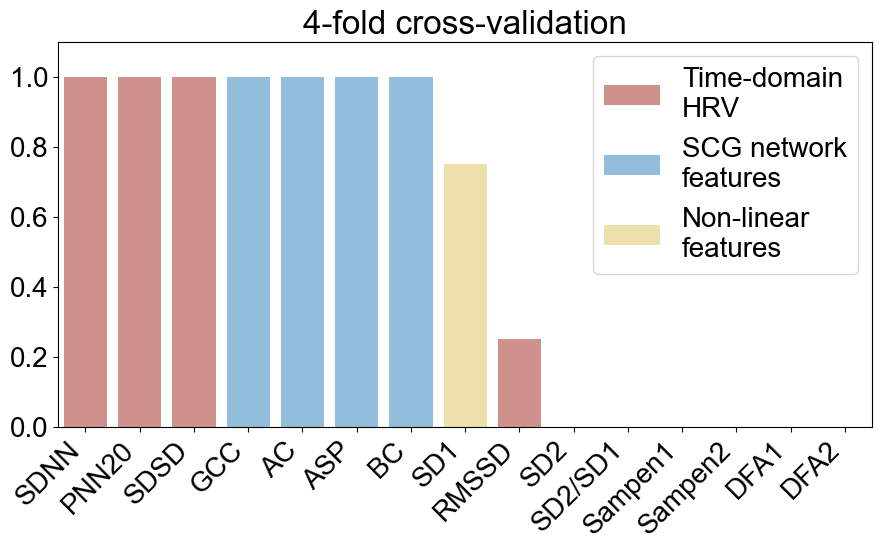

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_22850/847862777.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


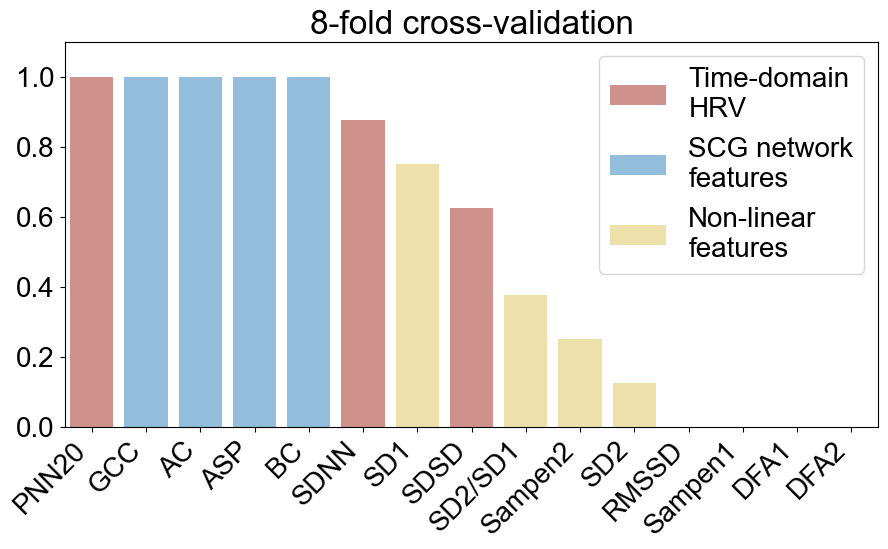

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_22850/847862777.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


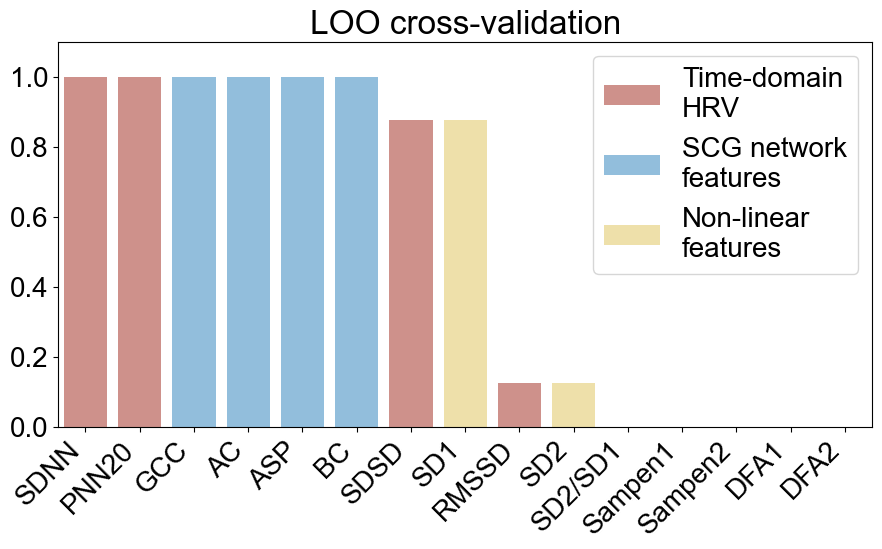

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_22850/847862777.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


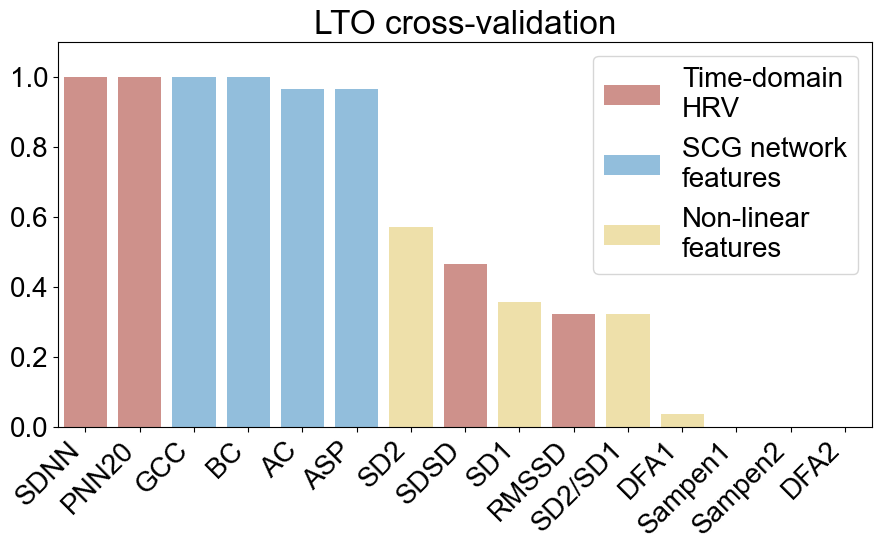

In [121]:
plot_4fold_fc=plot4feature_count(feature_count_4fold, '4-fold')
plot_8fold_fc=plot4feature_count(feature_count_8fold, '8-fold')
plot_1s_fc=plot4feature_count(feature_count_1s, 'LOO')
plot_2s_fc=plot4feature_count(feature_count_2s, 'LTO')

plot_4fold_fc.get_figure().savefig('4fold_feature_count.svg')
plot_8fold_fc.get_figure().savefig('8fold_feature_count.svg')
plot_1s_fc.get_figure().savefig('1s_feature_count.svg')
plot_2s_fc.get_figure().savefig('2s_feature_count.svg')

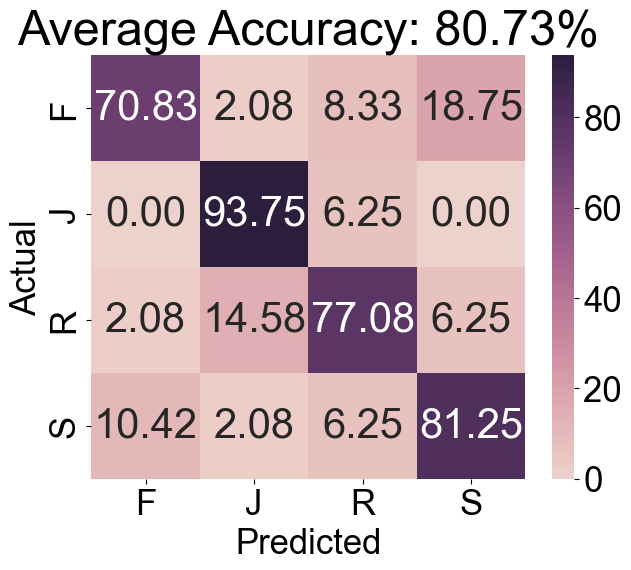

In [97]:
classes = ['F', 'J', 'R', 'S']
# 绘制测试集混淆矩阵
plt.figure(figsize=(7, 5.5))
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=25
cm_4fold_plot = sns.heatmap(cm_sd_4fold, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt=".2f", xticklabels=classes, yticklabels=classes, annot_kws={"size": 30})
plt.title(f'Average Accuracy: {"{:.2f}".format(avg_acc_4fold*100)}%',fontsize=35)
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm_4fold_plot.get_figure().savefig('4foldcm.svg')
plt.show()

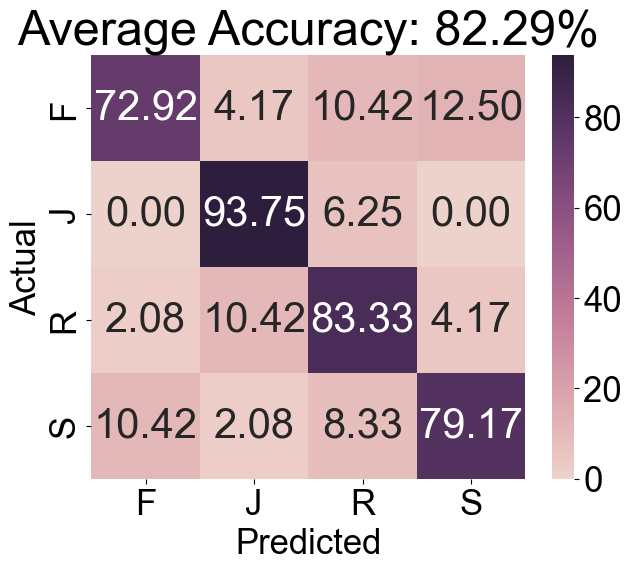

In [98]:
classes = ['F', 'J', 'R', 'S']
# 绘制测试集混淆矩阵
plt.figure(figsize=(7, 5.5))
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=25
cm_4fold_plot = sns.heatmap(cm_sd_8fold, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt=".2f", xticklabels=classes, yticklabels=classes, annot_kws={"size": 30})
plt.title(f'Average Accuracy: {"{:.2f}".format(avg_acc_8fold*100)}%',fontsize=35)
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm_4fold_plot.get_figure().savefig('8foldcm.svg')
plt.show()

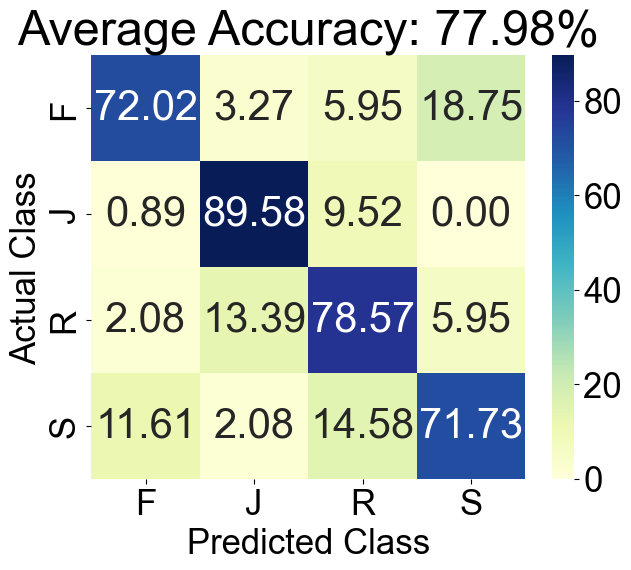

In [102]:
classes = ['F', 'J', 'R', 'S']
# 绘制测试集混淆矩阵
plt.figure(figsize=(7, 5.5))
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=25
cm_2s_plot = sns.heatmap(cm_2s, annot=True, cmap="YlGnBu", fmt=".2f", xticklabels=classes, yticklabels=classes, annot_kws={"size": 30})
plt.title(f'Average Accuracy: {"{:.2f}".format(avg_acc_2s*100)}%',fontsize=35)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
cm_2s_plot.get_figure().savefig('2scm.svg')
plt.show()

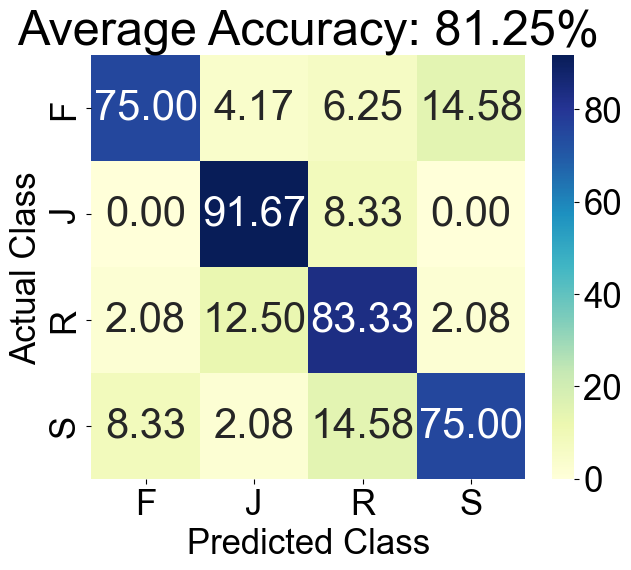

In [103]:
classes = ['F', 'J', 'R', 'S']
# 绘制测试集混淆矩阵
plt.figure(figsize=(7, 5.5))
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=25
cm_1s_plot = sns.heatmap(cm_1s, annot=True, cmap="YlGnBu", fmt=".2f", xticklabels=classes, yticklabels=classes, annot_kws={"size": 30})
plt.title(f'Average Accuracy: {"{:.2f}".format(avg_acc_1s*100)}%',fontsize=35)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
cm_1s_plot.get_figure().savefig('1scm.svg')
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

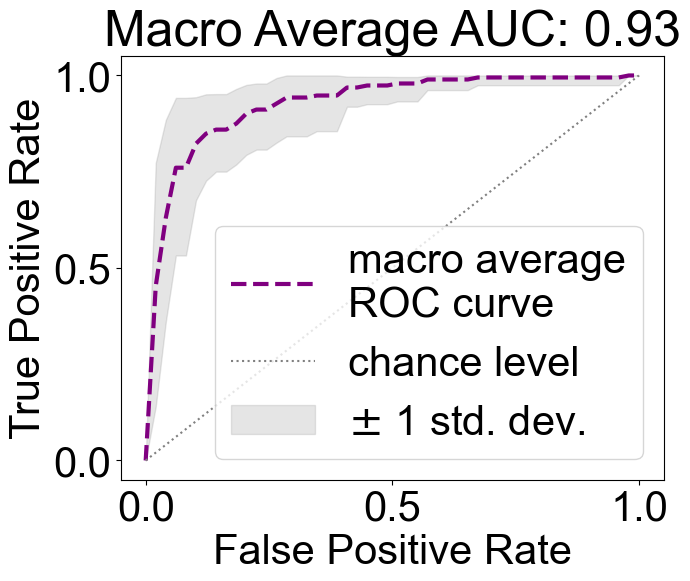

In [74]:
# ROC curve for 4fold
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=30
tprs_upper = np.minimum(tprs_mean_4fold + tprs_std_4fold, 1)
tprs_lower = np.maximum(tprs_mean_4fold - tprs_std_4fold, 0)
mean_fpr = mean_fpr=np.linspace(0,1,50)
fig, ax = plt.subplots(figsize=(7, 5.5))
classes = ['fear', 'joy', 'relaxation', 'sadness']
precision_4fold_mean = np.mean(precision_4fold,axis=0)
f1_4fold_mean = np.mean(f1_4fold,axis=0)
# for i in range(4):
#     sns.lineplot(data=None, x=mean_fpr, y=tprs_mean_4fold[i, :], label=f'{classes[i]}')
sns.lineplot(data=None, x=mean_fpr, y=np.mean(tprs_mean_4fold,axis=0), label=f'macro average\nROC curve ', linestyle='--', linewidth=3.0, color='purple')
sns.lineplot(data=None,x=[0, 1], y=[0, 1], linestyle=':', color='grey',label='chance level')
plt.fill_between(mean_fpr, tprs_upper.mean(axis=0), tprs_lower.mean(axis=0), color='grey', alpha=0.2, label=r"$\pm$ 1 std. dev.")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xticks([0.0, 0.5, 1.0])
plt.yticks([0.0, 0.5, 1.0])
legend = plt.legend()

# # 插入Precision和F1 Score的子图
# inset_ax = fig.add_axes([0.48, 0.15, 0.42, 0.3])  # [X, Y, width, height]

# bar_width = 0.35
# index = np.arange(len(classes))

# # 绘制条形图
# rects1 = inset_ax.bar(index, precision_4fold_mean, bar_width, label='Precision')
# rects2 = inset_ax.bar(index + bar_width, f1_4fold_mean, bar_width, label='F1 Score')

# # 设置子图标签和标题
# # inset_ax.set_xlabel('Class')
# # inset_ax.set_ylabel('Scores')
# inset_ax.set_xticks(index + bar_width / 2)
# inset_ax.set_xticklabels(classes, fontsize=10)
# inset_ax.set_yticklabels(inset_ax.get_yticks(), fontsize=10) 
# inset_ax.set_title('Precision and F1 Score', fontsize=12)

# # 调整子图y轴范围以容纳所有标签
# inset_ax.set_ylim(0, 1.1)

# # 添加精确值标签
# def add_labels(rects):
#     for rect in rects:
#         height = rect.get_height()
#         inset_ax.annotate(f'{height:.2f}',
#                           xy=(rect.get_x() + rect.get_width() / 2, height),
#                           xytext=(0, 3),  # 3 points vertical offset
#                           textcoords="offset points",
#                           ha='center', va='bottom',fontsize=10)

# add_labels(rects1)
# add_labels(rects2)

# # 获取子图图例句柄和标签
# sub_handles, sub_labels = inset_ax.get_legend_handles_labels()
# inset_ax.legend().remove() 
# inset_ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
# inset_ax.yaxis.set_ticklabels([])      # 隐藏 y 轴标签

# # 设置主图图例，并添加子图图例信息
# main_handles, main_labels = ax.get_legend_handles_labels()
# combined_handles = main_handles + sub_handles
# combined_labels = main_labels + sub_labels

# legend = ax.legend(combined_handles, combined_labels, loc='center left', bbox_to_anchor=(1.0, 0.7), fontsize=12)
plt.setp(legend.texts)
plt.title(f'Macro Average AUC: {"{:.2f}".format(auc_mean_4fold)}')
plt.savefig('4foldROC.svg', bbox_inches='tight', pad_inches=0.1)
plt.savefig('4foldROC.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

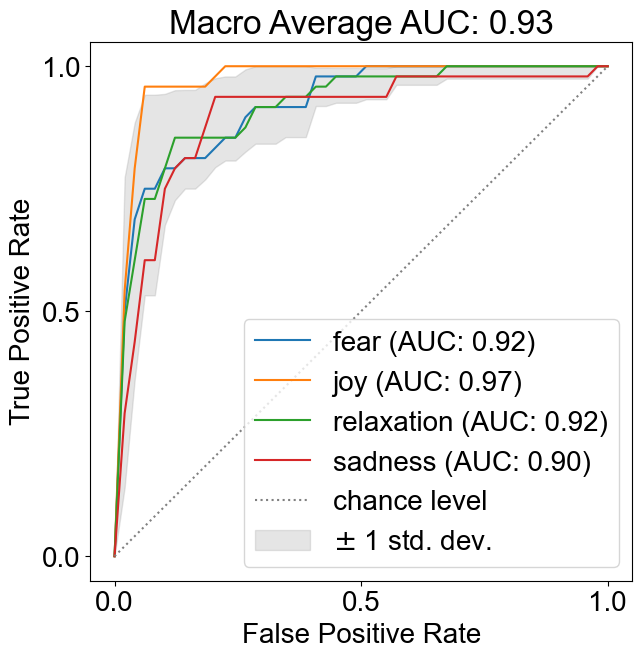

In [75]:
# ROC curve for 4fold
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=20
tprs_upper = np.minimum(tprs_mean_4fold + tprs_std_4fold, 1)
tprs_lower = np.maximum(tprs_mean_4fold - tprs_std_4fold, 0)
mean_fpr = mean_fpr=np.linspace(0,1,50)
fig, ax = plt.subplots(figsize=(7, 7))
classes = ['fear', 'joy', 'relaxation', 'sadness']
precision_4fold_mean = np.mean(precision_4fold,axis=0)
f1_4fold_mean = np.mean(f1_4fold,axis=0)
for i in range(4):
    sns.lineplot(data=None, x=mean_fpr, y=tprs_mean_4fold[i, :], label=f'{classes[i]} (AUC: {auc_emotion_4fold[0,i]:.2f})')
# sns.lineplot(data=None, x=mean_fpr, y=np.mean(tprs_mean_4fold,axis=0), label=f'macro average\nROC curve ', linestyle='--', linewidth=3.0, color='purple')
sns.lineplot(data=None,x=[0, 1], y=[0, 1], linestyle=':', color='grey',label='chance level')
plt.fill_between(mean_fpr, tprs_upper.mean(axis=0), tprs_lower.mean(axis=0), color='grey', alpha=0.2, label=r"$\pm$ 1 std. dev.")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xticks([0.0, 0.5, 1.0])
plt.yticks([0.0, 0.5, 1.0])
legend = plt.legend()

# # 插入Precision和F1 Score的子图
# inset_ax = fig.add_axes([0.48, 0.15, 0.42, 0.3])  # [X, Y, width, height]

# bar_width = 0.35
# index = np.arange(len(classes))

# # 绘制条形图
# rects1 = inset_ax.bar(index, precision_4fold_mean, bar_width, label='Precision')
# rects2 = inset_ax.bar(index + bar_width, f1_4fold_mean, bar_width, label='F1 Score')

# # 设置子图标签和标题
# # inset_ax.set_xlabel('Class')
# # inset_ax.set_ylabel('Scores')
# inset_ax.set_xticks(index + bar_width / 2)
# inset_ax.set_xticklabels(classes, fontsize=10)
# inset_ax.set_yticklabels(inset_ax.get_yticks(), fontsize=10) 
# inset_ax.set_title('Precision and F1 Score', fontsize=12)

# # 调整子图y轴范围以容纳所有标签
# inset_ax.set_ylim(0, 1.1)

# # 添加精确值标签
# def add_labels(rects):
#     for rect in rects:
#         height = rect.get_height()
#         inset_ax.annotate(f'{height:.2f}',
#                           xy=(rect.get_x() + rect.get_width() / 2, height),
#                           xytext=(0, 3),  # 3 points vertical offset
#                           textcoords="offset points",
#                           ha='center', va='bottom',fontsize=10)

# add_labels(rects1)
# add_labels(rects2)

# # 获取子图图例句柄和标签
# sub_handles, sub_labels = inset_ax.get_legend_handles_labels()
# inset_ax.legend().remove() 
# inset_ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
# inset_ax.yaxis.set_ticklabels([])      # 隐藏 y 轴标签

# # 设置主图图例，并添加子图图例信息
# main_handles, main_labels = ax.get_legend_handles_labels()
# combined_handles = main_handles + sub_handles
# combined_labels = main_labels + sub_labels

# legend = ax.legend(combined_handles, combined_labels, loc='center left', bbox_to_anchor=(1.0, 0.7), fontsize=12)
plt.setp(legend.texts)
plt.title(f'Macro Average AUC: {"{:.2f}".format(auc_mean_4fold)}')
plt.savefig('4foldROC_4e.svg', bbox_inches='tight', pad_inches=0.1)
plt.savefig('4foldROC_4e.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_22850/1238108244.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=25)


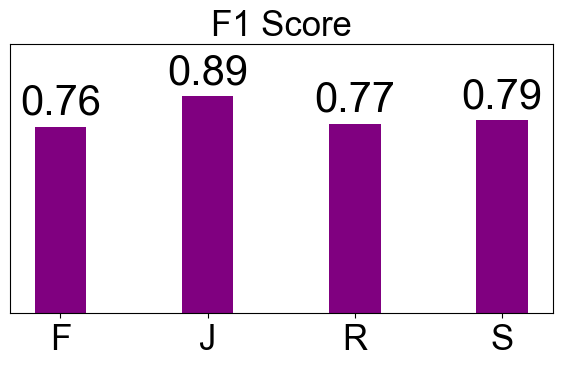

In [76]:
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=25
fig, ax = plt.subplots(figsize=(7, 3.5))
classes = ['F', 'J', 'R', 'S']
bar_width = 0.35
index = np.arange(len(classes))

# 绘制条形图
# rects1 = ax.bar(index, precision_4fold_mean, bar_width, label='Precision')
rects2 = ax.bar(index + 0.5*bar_width, f1_4fold_mean, bar_width, label='F1 Score', color='#800080')

# 设置子图标签和标题
# inset_ax.set_xlabel('Class')
# inset_ax.set_ylabel('Scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classes, fontsize=25)
ax.set_yticklabels(ax.get_yticks(), fontsize=25) 
ax.set_title('F1 Score', fontsize=25)

# 调整子图y轴范围以容纳所有标签
ax.set_ylim(0, 1.1)

# 添加精确值标签
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom',fontsize=30)

# add_labels(rects1)
add_labels(rects2)

# 获取子图图例句柄和标签
sub_handles, sub_labels =ax.get_legend_handles_labels()
ax.legend().remove() 
ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
ax.yaxis.set_ticklabels([])      # 隐藏 y 轴标签

plt.savefig('4foldf1score.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_22850/3609834849.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=25)


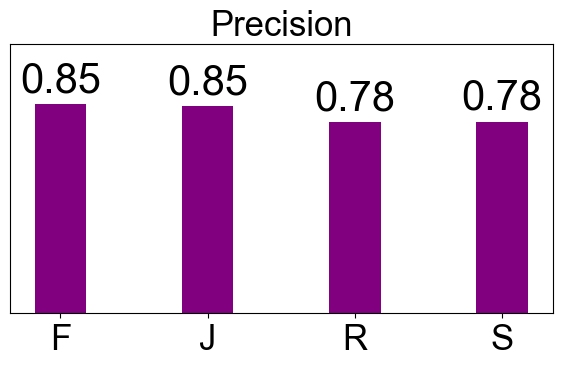

In [77]:
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=25
fig, ax = plt.subplots(figsize=(7, 3.5))
classes = ['F', 'J', 'R', 'S']
bar_width = 0.35
index = np.arange(len(classes))

# 绘制条形图
# rects1 = ax.bar(index, precision_4fold_mean, bar_width, label='Precision')
rects2 = ax.bar(index + 0.5*bar_width, precision_4fold_mean, bar_width, label='Precision', color='#800080')

# 设置子图标签和标题
# inset_ax.set_xlabel('Class')
# inset_ax.set_ylabel('Scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classes, fontsize=25)
ax.set_yticklabels(ax.get_yticks(), fontsize=25) 
ax.set_title('Precision', fontsize=25)

# 调整子图y轴范围以容纳所有标签
ax.set_ylim(0, 1.1)

# 添加精确值标签
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom',fontsize=30)

# add_labels(rects1)
add_labels(rects2)

# 获取子图图例句柄和标签
sub_handles, sub_labels =ax.get_legend_handles_labels()
ax.legend().remove() 
ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
ax.yaxis.set_ticklabels([])      # 隐藏 y 轴标签

plt.savefig('4foldprecision.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

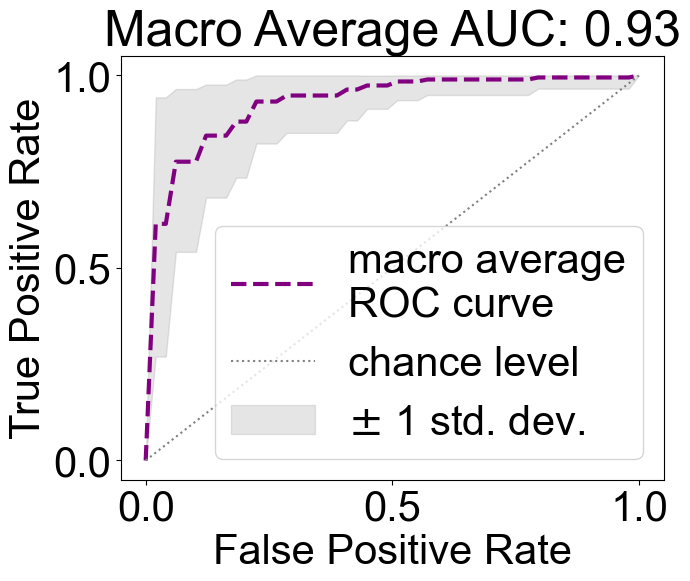

In [78]:
# ROC curve for 4fold
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=30
tprs_upper = np.minimum(tprs_mean_8fold + tprs_std_8fold, 1)
tprs_lower = np.maximum(tprs_mean_8fold - tprs_std_8fold, 0)
mean_fpr = mean_fpr=np.linspace(0,1,50)
fig, ax = plt.subplots(figsize=(7, 5.5))
classes = ['fear', 'joy', 'relaxation', 'sadness']
precision_8fold_mean = np.mean(precision_8fold,axis=0)
f1_8fold_mean = np.mean(f1_8fold,axis=0)
# for i in range(4):
#     sns.lineplot(data=None, x=mean_fpr, y=tprs_mean_4fold[i, :], label=f'{classes[i]}')
sns.lineplot(data=None, x=mean_fpr, y=np.mean(tprs_mean_8fold,axis=0), label=f'macro average\nROC curve ', linestyle='--', linewidth=3.0, color='purple')
sns.lineplot(data=None,x=[0, 1], y=[0, 1], linestyle=':', color='grey',label='chance level')
plt.fill_between(mean_fpr, tprs_upper.mean(axis=0), tprs_lower.mean(axis=0), color='grey', alpha=0.2, label=r"$\pm$ 1 std. dev.")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xticks([0.0, 0.5, 1.0])
plt.yticks([0.0, 0.5, 1.0])
legend = plt.legend()

# # 插入Precision和F1 Score的子图
# inset_ax = fig.add_axes([0.48, 0.15, 0.42, 0.3])  # [X, Y, width, height]

# bar_width = 0.35
# index = np.arange(len(classes))

# # 绘制条形图
# rects1 = inset_ax.bar(index, precision_4fold_mean, bar_width, label='Precision')
# rects2 = inset_ax.bar(index + bar_width, f1_4fold_mean, bar_width, label='F1 Score')

# # 设置子图标签和标题
# # inset_ax.set_xlabel('Class')
# # inset_ax.set_ylabel('Scores')
# inset_ax.set_xticks(index + bar_width / 2)
# inset_ax.set_xticklabels(classes, fontsize=10)
# inset_ax.set_yticklabels(inset_ax.get_yticks(), fontsize=10) 
# inset_ax.set_title('Precision and F1 Score', fontsize=12)

# # 调整子图y轴范围以容纳所有标签
# inset_ax.set_ylim(0, 1.1)

# # 添加精确值标签
# def add_labels(rects):
#     for rect in rects:
#         height = rect.get_height()
#         inset_ax.annotate(f'{height:.2f}',
#                           xy=(rect.get_x() + rect.get_width() / 2, height),
#                           xytext=(0, 3),  # 3 points vertical offset
#                           textcoords="offset points",
#                           ha='center', va='bottom',fontsize=10)

# add_labels(rects1)
# add_labels(rects2)

# # 获取子图图例句柄和标签
# sub_handles, sub_labels = inset_ax.get_legend_handles_labels()
# inset_ax.legend().remove() 
# inset_ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
# inset_ax.yaxis.set_ticklabels([])      # 隐藏 y 轴标签

# # 设置主图图例，并添加子图图例信息
# main_handles, main_labels = ax.get_legend_handles_labels()
# combined_handles = main_handles + sub_handles
# combined_labels = main_labels + sub_labels

# legend = ax.legend(combined_handles, combined_labels, loc='center left', bbox_to_anchor=(1.0, 0.7), fontsize=12)
plt.setp(legend.texts)
plt.title(f'Macro Average AUC: {"{:.2f}".format(auc_mean_8fold)}')
plt.savefig('8foldROC.svg', bbox_inches='tight', pad_inches=0.1)
plt.savefig('8foldROC.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

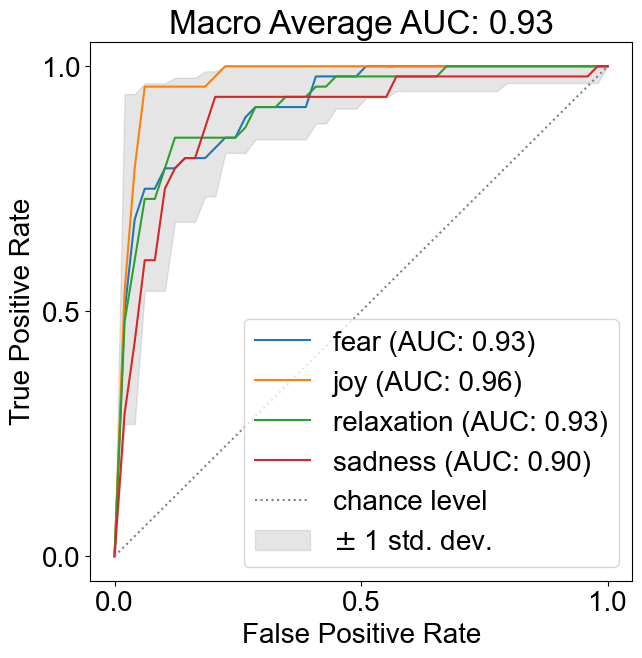

In [79]:
# ROC curve for 4fold
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=20
tprs_upper = np.minimum(tprs_mean_8fold + tprs_std_8fold, 1)
tprs_lower = np.maximum(tprs_mean_8fold - tprs_std_8fold, 0)
mean_fpr = mean_fpr=np.linspace(0,1,50)
fig, ax = plt.subplots(figsize=(7, 7))
classes = ['fear', 'joy', 'relaxation', 'sadness']
precision_8fold_mean = np.mean(precision_8fold,axis=0)
f1_8fold_mean = np.mean(f1_8fold,axis=0)
for i in range(4):
    sns.lineplot(data=None, x=mean_fpr, y=tprs_mean_4fold[i, :], label=f'{classes[i]} (AUC: {auc_emotion_8fold[0,i]:.2f})')
# sns.lineplot(data=None, x=mean_fpr, y=np.mean(tprs_mean_8fold,axis=0), label=f'macro average\nROC curve ', linestyle='--', linewidth=3.0, color='purple')
sns.lineplot(data=None,x=[0, 1], y=[0, 1], linestyle=':', color='grey',label='chance level')
plt.fill_between(mean_fpr, tprs_upper.mean(axis=0), tprs_lower.mean(axis=0), color='grey', alpha=0.2, label=r"$\pm$ 1 std. dev.")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xticks([0.0, 0.5, 1.0])
plt.yticks([0.0, 0.5, 1.0])
legend = plt.legend()

# # 插入Precision和F1 Score的子图
# inset_ax = fig.add_axes([0.48, 0.15, 0.42, 0.3])  # [X, Y, width, height]

# bar_width = 0.35
# index = np.arange(len(classes))

# # 绘制条形图
# rects1 = inset_ax.bar(index, precision_4fold_mean, bar_width, label='Precision')
# rects2 = inset_ax.bar(index + bar_width, f1_4fold_mean, bar_width, label='F1 Score')

# # 设置子图标签和标题
# # inset_ax.set_xlabel('Class')
# # inset_ax.set_ylabel('Scores')
# inset_ax.set_xticks(index + bar_width / 2)
# inset_ax.set_xticklabels(classes, fontsize=10)
# inset_ax.set_yticklabels(inset_ax.get_yticks(), fontsize=10) 
# inset_ax.set_title('Precision and F1 Score', fontsize=12)

# # 调整子图y轴范围以容纳所有标签
# inset_ax.set_ylim(0, 1.1)

# # 添加精确值标签
# def add_labels(rects):
#     for rect in rects:
#         height = rect.get_height()
#         inset_ax.annotate(f'{height:.2f}',
#                           xy=(rect.get_x() + rect.get_width() / 2, height),
#                           xytext=(0, 3),  # 3 points vertical offset
#                           textcoords="offset points",
#                           ha='center', va='bottom',fontsize=10)

# add_labels(rects1)
# add_labels(rects2)

# # 获取子图图例句柄和标签
# sub_handles, sub_labels = inset_ax.get_legend_handles_labels()
# inset_ax.legend().remove() 
# inset_ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
# inset_ax.yaxis.set_ticklabels([])      # 隐藏 y 轴标签

# # 设置主图图例，并添加子图图例信息
# main_handles, main_labels = ax.get_legend_handles_labels()
# combined_handles = main_handles + sub_handles
# combined_labels = main_labels + sub_labels

# legend = ax.legend(combined_handles, combined_labels, loc='center left', bbox_to_anchor=(1.0, 0.7), fontsize=12)
plt.setp(legend.texts)
plt.title(f'Macro Average AUC: {"{:.2f}".format(auc_mean_8fold)}')
plt.savefig('8foldROC_4e.svg', bbox_inches='tight', pad_inches=0.1)
plt.savefig('8foldROC_4e.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_22850/924371180.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=25)


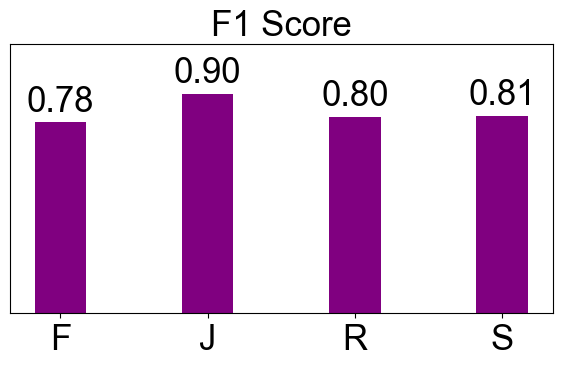

In [80]:
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=25
fig, ax = plt.subplots(figsize=(7, 3.5))
classes = ['F', 'J', 'R', 'S']
bar_width = 0.35
index = np.arange(len(classes))

# 绘制条形图
# rects1 = ax.bar(index, precision_4fold_mean, bar_width, label='Precision')
rects2 = ax.bar(index + 0.5*bar_width, f1_8fold_mean, bar_width, label='F1 Score', color='#800080')

# 设置子图标签和标题
# inset_ax.set_xlabel('Class')
# inset_ax.set_ylabel('Scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classes, fontsize=25)
ax.set_yticklabels(ax.get_yticks(), fontsize=25) 
ax.set_title('F1 Score', fontsize=25)

# 调整子图y轴范围以容纳所有标签
ax.set_ylim(0, 1.1)

# 添加精确值标签
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom',fontsize=25)

# add_labels(rects1)
add_labels(rects2)

# 获取子图图例句柄和标签
sub_handles, sub_labels =ax.get_legend_handles_labels()
ax.legend().remove() 
ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
ax.yaxis.set_ticklabels([])      # 隐藏 y 轴标签

plt.savefig('8foldf1score.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_22850/3096711238.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=25)


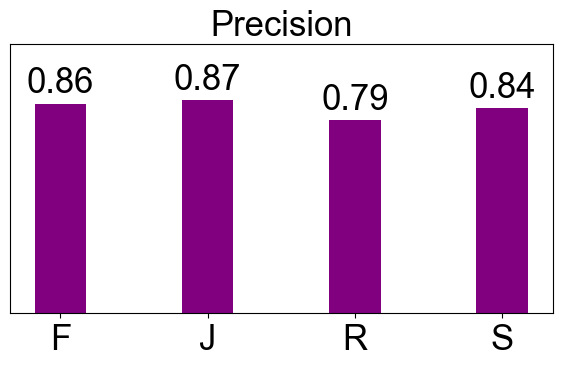

In [81]:
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=25
fig, ax = plt.subplots(figsize=(7, 3.5))
classes = ['F', 'J', 'R', 'S']
bar_width = 0.35
index = np.arange(len(classes))

# 绘制条形图
# rects1 = ax.bar(index, precision_4fold_mean, bar_width, label='Precision')
rects2 = ax.bar(index + 0.5*bar_width, precision_8fold_mean, bar_width, label='Precision', color='#800080')

# 设置子图标签和标题
# inset_ax.set_xlabel('Class')
# inset_ax.set_ylabel('Scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classes, fontsize=25)
ax.set_yticklabels(ax.get_yticks(), fontsize=25) 
ax.set_title('Precision', fontsize=25)

# 调整子图y轴范围以容纳所有标签
ax.set_ylim(0, 1.1)

# 添加精确值标签
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom',fontsize=25)

# add_labels(rects1)
add_labels(rects2)

# 获取子图图例句柄和标签
sub_handles, sub_labels =ax.get_legend_handles_labels()
ax.legend().remove() 
ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
ax.yaxis.set_ticklabels([])      # 隐藏 y 轴标签

plt.savefig('8foldprecision_4e.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

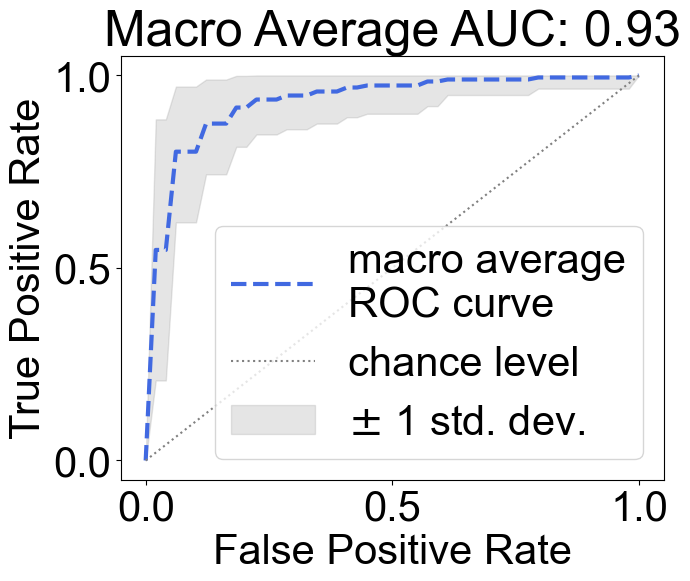

In [82]:
# ROC curve for 1s
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=30
tprs_upper = np.minimum(tprs_mean_1s + tprs_std_1s, 1)
tprs_lower = np.maximum(tprs_mean_1s - tprs_std_1s, 0)
mean_fpr = mean_fpr=np.linspace(0,1,50)
fig, ax = plt.subplots(figsize=(7, 5.5))
classes = ['fear', 'joy', 'relaxed', 'sad']
precision_1s_mean = np.mean(precision_1s,axis=0)
f1_1s_mean = np.mean(f1_1s,axis=0)
# for i in range(4):
#     sns.lineplot(data=None, x=mean_fpr, y=tprs_mean_1s[i, :], label=f'{classes[i]} (AUC: {auc_emotion_1s[0,i]:.2f})')
sns.lineplot(data=None, x=mean_fpr, y=np.mean(tprs_mean_1s,axis=0), label=f'macro average\nROC curve', linestyle='--', linewidth=3.0,color='#4169E1')
sns.lineplot(data=None,x=[0, 1], y=[0, 1], linestyle=':', color='grey',label='chance level')
plt.fill_between(mean_fpr, tprs_upper.mean(axis=0), tprs_lower.mean(axis=0), color='grey', alpha=0.2, label=r"$\pm$ 1 std. dev.")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xticks([0.0, 0.5, 1.0])
plt.yticks([0.0, 0.5, 1.0])
legend = plt.legend()

# # 插入Precision和F1 Score的子图
# inset_ax = fig.add_axes([0.48, 0.15, 0.42, 0.3])  # [X, Y, width, height]

# bar_width = 0.35
# index = np.arange(len(classes))

# # 绘制条形图
# rects1 = inset_ax.bar(index, precision_1s_mean, bar_width, label='Precision')
# rects2 = inset_ax.bar(index + bar_width, f1_1s_mean, bar_width, label='F1 Score')

# # 设置子图标签和标题
# # inset_ax.set_xlabel('Class')
# # inset_ax.set_ylabel('Scores')
# inset_ax.set_xticks(index + bar_width / 2)
# inset_ax.set_xticklabels(classes, fontsize=10)
# inset_ax.set_yticklabels(inset_ax.get_yticks(), fontsize=10) 
# inset_ax.set_title('Precision and F1 Score', fontsize=12)

# # 调整子图y轴范围以容纳所有标签
# inset_ax.set_ylim(0, 1.1)

# # 添加精确值标签
# def add_labels(rects):
#     for rect in rects:
#         height = rect.get_height()
#         inset_ax.annotate(f'{height:.2f}',
#                           xy=(rect.get_x() + rect.get_width() / 2, height),
#                           xytext=(0, 3),  # 3 points vertical offset
#                           textcoords="offset points",
#                           ha='center', va='bottom',fontsize=10)
# # 添加精确值标签

# add_labels(rects1)
# add_labels(rects2)

# # 获取子图图例句柄和标签
# sub_handles, sub_labels = inset_ax.get_legend_handles_labels()
# inset_ax.legend().remove() 
# inset_ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
# inset_ax.yaxis.set_ticklabels([])     

# # 设置主图图例，并添加子图图例信息
# main_handles, main_labels = ax.get_legend_handles_labels()
# combined_handles = main_handles + sub_handles
# combined_labels = main_labels + sub_labels

# legend = ax.legend(combined_handles, combined_labels, loc='center left', bbox_to_anchor=(1.0, 0.7), fontsize=25)
# plt.setp(legend.texts, fontsize=16)
plt.title(f'Macro Average AUC: {"{:.2f}".format(auc_mean_1s)}')
plt.savefig('1sROC.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

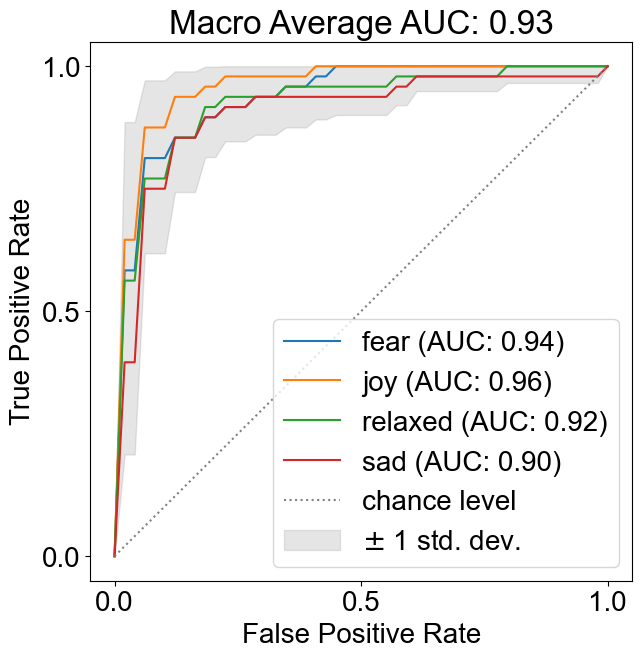

In [83]:
# ROC curve for 1s
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=20
tprs_upper = np.minimum(tprs_mean_1s + tprs_std_1s, 1)
tprs_lower = np.maximum(tprs_mean_1s - tprs_std_1s, 0)
mean_fpr = mean_fpr=np.linspace(0,1,50)
fig, ax = plt.subplots(figsize=(7, 7))
classes = ['fear', 'joy', 'relaxed', 'sad']
precision_1s_mean = np.mean(precision_1s,axis=0)
f1_1s_mean = np.mean(f1_1s,axis=0)
for i in range(4):
    sns.lineplot(data=None, x=mean_fpr, y=tprs_mean_1s[i, :], label=f'{classes[i]} (AUC: {auc_emotion_1s[0,i]:.2f})')
# sns.lineplot(data=None, x=mean_fpr, y=np.mean(tprs_mean_1s,axis=0), label=f'macro average\nROC curve', linestyle='--', linewidth=3.0,color='#4169E1')
sns.lineplot(data=None,x=[0, 1], y=[0, 1], linestyle=':', color='grey',label='chance level')
plt.fill_between(mean_fpr, tprs_upper.mean(axis=0), tprs_lower.mean(axis=0), color='grey', alpha=0.2, label=r"$\pm$ 1 std. dev.")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xticks([0.0, 0.5, 1.0])
plt.yticks([0.0, 0.5, 1.0])
legend = plt.legend()

# # 插入Precision和F1 Score的子图
# inset_ax = fig.add_axes([0.48, 0.15, 0.42, 0.3])  # [X, Y, width, height]

# bar_width = 0.35
# index = np.arange(len(classes))

# # 绘制条形图
# rects1 = inset_ax.bar(index, precision_1s_mean, bar_width, label='Precision')
# rects2 = inset_ax.bar(index + bar_width, f1_1s_mean, bar_width, label='F1 Score')

# # 设置子图标签和标题
# # inset_ax.set_xlabel('Class')
# # inset_ax.set_ylabel('Scores')
# inset_ax.set_xticks(index + bar_width / 2)
# inset_ax.set_xticklabels(classes, fontsize=10)
# inset_ax.set_yticklabels(inset_ax.get_yticks(), fontsize=10) 
# inset_ax.set_title('Precision and F1 Score', fontsize=12)

# # 调整子图y轴范围以容纳所有标签
# inset_ax.set_ylim(0, 1.1)

# # 添加精确值标签
# def add_labels(rects):
#     for rect in rects:
#         height = rect.get_height()
#         inset_ax.annotate(f'{height:.2f}',
#                           xy=(rect.get_x() + rect.get_width() / 2, height),
#                           xytext=(0, 3),  # 3 points vertical offset
#                           textcoords="offset points",
#                           ha='center', va='bottom',fontsize=10)
# # 添加精确值标签

# add_labels(rects1)
# add_labels(rects2)

# # 获取子图图例句柄和标签
# sub_handles, sub_labels = inset_ax.get_legend_handles_labels()
# inset_ax.legend().remove() 
# inset_ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
# inset_ax.yaxis.set_ticklabels([])     

# # 设置主图图例，并添加子图图例信息
# main_handles, main_labels = ax.get_legend_handles_labels()
# combined_handles = main_handles + sub_handles
# combined_labels = main_labels + sub_labels

# legend = ax.legend(combined_handles, combined_labels, loc='center left', bbox_to_anchor=(1.0, 0.7), fontsize=25)
# plt.setp(legend.texts, fontsize=16)
plt.title(f'Macro Average AUC: {"{:.2f}".format(auc_mean_1s)}')
plt.savefig('1sROC_4e.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_22850/731773713.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=25)


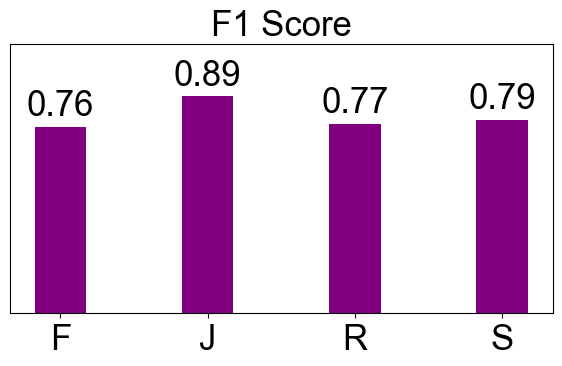

In [84]:
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=25
fig, ax = plt.subplots(figsize=(7, 3.5))
classes = ['F', 'J', 'R', 'S']
bar_width = 0.35
index = np.arange(len(classes))

# 绘制条形图
# rects1 = ax.bar(index, precision_4fold_mean, bar_width, label='Precision')
rects2 = ax.bar(index + 0.5*bar_width, f1_4fold_mean, bar_width, label='F1 Score', color='#800080')

# 设置子图标签和标题
# inset_ax.set_xlabel('Class')
# inset_ax.set_ylabel('Scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classes, fontsize=25)
ax.set_yticklabels(ax.get_yticks(), fontsize=25) 
ax.set_title('F1 Score', fontsize=25)

# 调整子图y轴范围以容纳所有标签
ax.set_ylim(0, 1.1)

# 添加精确值标签
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom',fontsize=25)

# add_labels(rects1)
add_labels(rects2)

# 获取子图图例句柄和标签
sub_handles, sub_labels =ax.get_legend_handles_labels()
ax.legend().remove() 
ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
ax.yaxis.set_ticklabels([])      # 隐藏 y 轴标签

plt.savefig('4foldf1score.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

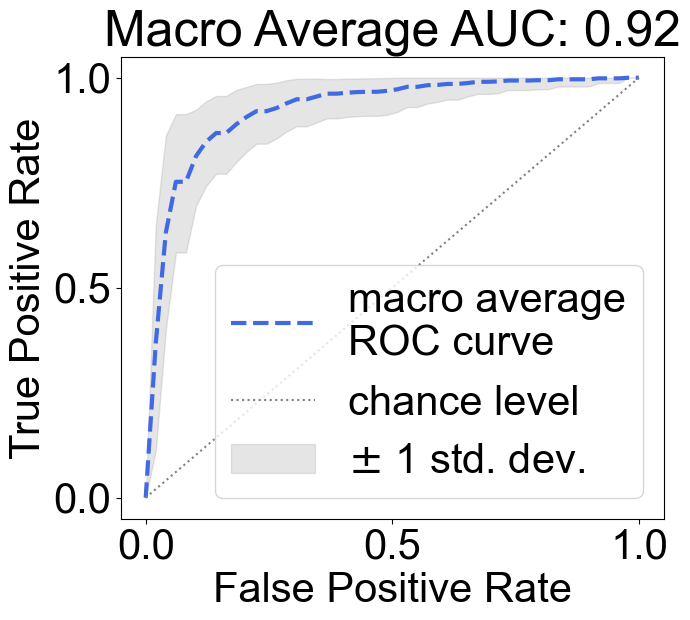

In [85]:
# ROC curve for 2s
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=30
tprs_upper = np.minimum(tprs_mean_2s + tprs_std_2s, 1)
tprs_lower = np.maximum(tprs_mean_2s - tprs_std_2s, 0)
mean_fpr = mean_fpr=np.linspace(0,1,50)
fig, ax = plt.subplots(figsize=(7, 6))
classes = ['fear', 'joy', 'relaxed', 'sad']
precision_2s_mean = np.mean(precission_2s,axis=0)
f1_2s_mean = np.mean(f1_2s,axis=0)
# for i in range(4):
#     sns.lineplot(data=None, x=mean_fpr, y=tprs_mean_2s[i, :], label=f'{classes[i]} (AUC: {auc_emotion_2s[0,i]:.2f})')
sns.lineplot(data=None, x=mean_fpr, y=np.mean(tprs_mean_2s,axis=0), label=f'macro average\nROC curve', linestyle='--', linewidth=3.0,color='#4169E1')
sns.lineplot(data=None,x=[0, 1], y=[0, 1], linestyle=':', color='grey',label='chance level')
plt.fill_between(mean_fpr, tprs_upper.mean(axis=0), tprs_lower.mean(axis=0), color='grey', alpha=0.2, label=r"$\pm$ 1 std. dev.")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xticks([0.0, 0.5, 1.0])
plt.yticks([0.0, 0.5, 1.0])
legend = plt.legend()

# # 插入Precision和F1 Score的子图
# inset_ax = fig.add_axes([0.48, 0.15, 0.42, 0.3])  # [X, Y, width, height]

# bar_width = 0.35
# index = np.arange(len(classes))

# # 绘制条形图
# rects1 = inset_ax.bar(index, precision_2s_mean, bar_width, label='Precision')
# rects2 = inset_ax.bar(index + bar_width, f1_2s_mean, bar_width, label='F1 Score')

# # 设置子图标签和标题
# # inset_ax.set_xlabel('Class')
# # inset_ax.set_ylabel('Scores')
# inset_ax.set_xticks(index + bar_width / 2)
# inset_ax.set_xticklabels(classes, fontsize=10)
# inset_ax.set_yticklabels(inset_ax.get_yticks(), fontsize=10) 
# inset_ax.set_title('Precision and F1 Score', fontsize=12)

# # 调整子图y轴范围以容纳所有标签
# inset_ax.set_ylim(0, 1.1)

# # 添加精确值标签
# def add_labels(rects):
#     for rect in rects:
#         height = rect.get_height()
#         inset_ax.annotate(f'{height:.2f}',
#                           xy=(rect.get_x() + rect.get_width() / 2, height),
#                           xytext=(0, 3),  # 3 points vertical offset
#                           textcoords="offset points",
#                           ha='center', va='bottom', fontsize=10)

# add_labels(rects1)
# add_labels(rects2)

# # 获取子图图例句柄和标签
# sub_handles, sub_labels = inset_ax.get_legend_handles_labels()
# inset_ax.legend().remove() 
# inset_ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
# inset_ax.yaxis.set_ticklabels([]) 

# # 设置主图图例，并添加子图图例信息
# main_handles, main_labels = ax.get_legend_handles_labels()
# combined_handles = main_handles + sub_handles
# combined_labels = main_labels + sub_labels

# legend = ax.legend(combined_handles, combined_labels, loc='center left', bbox_to_anchor=(1.0, 0.7), fontsize=12)
plt.title(f'Macro Average AUC: {"{:.2f}".format(auc_mean_2s)}')
plt.savefig('2sROC.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

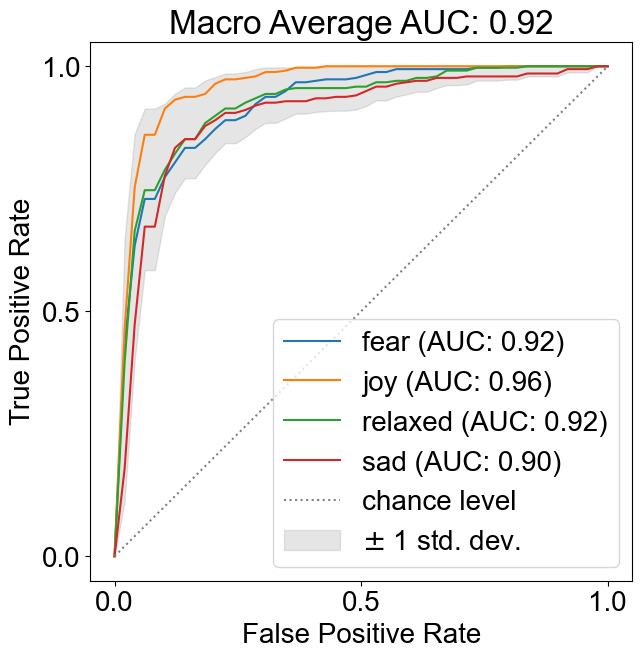

In [86]:
# ROC curve for 2s
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=20
tprs_upper = np.minimum(tprs_mean_2s + tprs_std_2s, 1)
tprs_lower = np.maximum(tprs_mean_2s - tprs_std_2s, 0)
mean_fpr = mean_fpr=np.linspace(0,1,50)
fig, ax = plt.subplots(figsize=(7, 7))
classes = ['fear', 'joy', 'relaxed', 'sad']
precision_2s_mean = np.mean(precission_2s,axis=0)
f1_2s_mean = np.mean(f1_2s,axis=0)
for i in range(4):
    sns.lineplot(data=None, x=mean_fpr, y=tprs_mean_2s[i, :], label=f'{classes[i]} (AUC: {auc_emotion_2s[0,i]:.2f})')
# sns.lineplot(data=None, x=mean_fpr, y=np.mean(tprs_mean_2s,axis=0), label=f'macro average\nROC curve', linestyle='--', linewidth=3.0,color='#4169E1')
sns.lineplot(data=None,x=[0, 1], y=[0, 1], linestyle=':', color='grey',label='chance level')
plt.fill_between(mean_fpr, tprs_upper.mean(axis=0), tprs_lower.mean(axis=0), color='grey', alpha=0.2, label=r"$\pm$ 1 std. dev.")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xticks([0.0, 0.5, 1.0])
plt.yticks([0.0, 0.5, 1.0])
legend = plt.legend()

# # 插入Precision和F1 Score的子图
# inset_ax = fig.add_axes([0.48, 0.15, 0.42, 0.3])  # [X, Y, width, height]

# bar_width = 0.35
# index = np.arange(len(classes))

# # 绘制条形图
# rects1 = inset_ax.bar(index, precision_2s_mean, bar_width, label='Precision')
# rects2 = inset_ax.bar(index + bar_width, f1_2s_mean, bar_width, label='F1 Score')

# # 设置子图标签和标题
# # inset_ax.set_xlabel('Class')
# # inset_ax.set_ylabel('Scores')
# inset_ax.set_xticks(index + bar_width / 2)
# inset_ax.set_xticklabels(classes, fontsize=10)
# inset_ax.set_yticklabels(inset_ax.get_yticks(), fontsize=10) 
# inset_ax.set_title('Precision and F1 Score', fontsize=12)

# # 调整子图y轴范围以容纳所有标签
# inset_ax.set_ylim(0, 1.1)

# # 添加精确值标签
# def add_labels(rects):
#     for rect in rects:
#         height = rect.get_height()
#         inset_ax.annotate(f'{height:.2f}',
#                           xy=(rect.get_x() + rect.get_width() / 2, height),
#                           xytext=(0, 3),  # 3 points vertical offset
#                           textcoords="offset points",
#                           ha='center', va='bottom', fontsize=10)

# add_labels(rects1)
# add_labels(rects2)

# # 获取子图图例句柄和标签
# sub_handles, sub_labels = inset_ax.get_legend_handles_labels()
# inset_ax.legend().remove() 
# inset_ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
# inset_ax.yaxis.set_ticklabels([]) 

# # 设置主图图例，并添加子图图例信息
# main_handles, main_labels = ax.get_legend_handles_labels()
# combined_handles = main_handles + sub_handles
# combined_labels = main_labels + sub_labels

# legend = ax.legend(combined_handles, combined_labels, loc='center left', bbox_to_anchor=(1.0, 0.7), fontsize=12)
plt.title(f'Macro Average AUC: {"{:.2f}".format(auc_mean_2s)}')
plt.savefig('2sROC_4e.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_22850/1119327646.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=25)


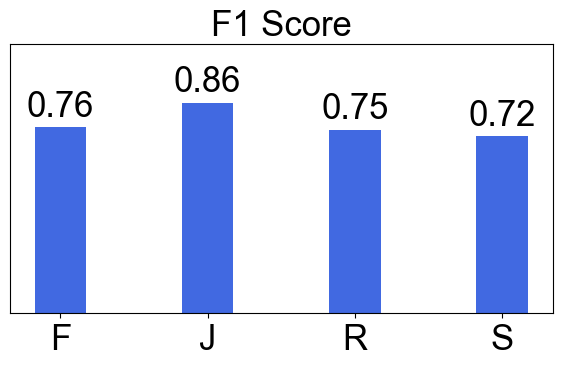

In [87]:
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=25
fig, ax = plt.subplots(figsize=(7, 3.5))
classes = ['F', 'J', 'R', 'S']
bar_width = 0.35
index = np.arange(len(classes))

# 绘制条形图
# rects1 = ax.bar(index, precision_4fold_mean, bar_width, label='Precision')
rects2 = ax.bar(index + 0.5*bar_width, f1_2s_mean, bar_width, label='F1 Score', color='#4169E1')

# 设置子图标签和标题
# inset_ax.set_xlabel('Class')
# inset_ax.set_ylabel('Scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classes, fontsize=25)
ax.set_yticklabels(ax.get_yticks(), fontsize=25) 
ax.set_title('F1 Score', fontsize=25)

# 调整子图y轴范围以容纳所有标签
ax.set_ylim(0, 1.1)

# 添加精确值标签
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom',fontsize=25)

# add_labels(rects1)
add_labels(rects2)

# 获取子图图例句柄和标签
sub_handles, sub_labels =ax.get_legend_handles_labels()
ax.legend().remove() 
ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
ax.yaxis.set_ticklabels([])      # 隐藏 y 轴标签

plt.savefig('2sf1score.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_22850/399118187.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=25)


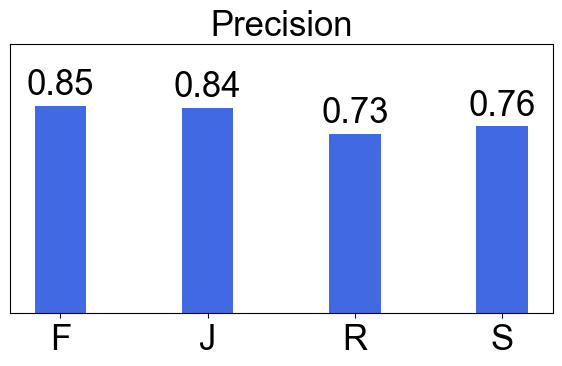

In [88]:
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=25
fig, ax = plt.subplots(figsize=(7, 3.5))
classes = ['F', 'J', 'R', 'S']
bar_width = 0.35
index = np.arange(len(classes))

# 绘制条形图
# rects1 = ax.bar(index, precision_4fold_mean, bar_width, label='Precision')
rects2 = ax.bar(index + 0.5*bar_width, precision_2s_mean, bar_width, label='Precision', color='#4169E1')

# 设置子图标签和标题
# inset_ax.set_xlabel('Class')
# inset_ax.set_ylabel('Scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classes, fontsize=25)
ax.set_yticklabels(ax.get_yticks(), fontsize=25) 
ax.set_title('Precision', fontsize=25)

# 调整子图y轴范围以容纳所有标签
ax.set_ylim(0, 1.1)

# 添加精确值标签
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom',fontsize=25)

# add_labels(rects1)
add_labels(rects2)

# 获取子图图例句柄和标签
sub_handles, sub_labels =ax.get_legend_handles_labels()
ax.legend().remove() 
ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
ax.yaxis.set_ticklabels([])      # 隐藏 y 轴标签

plt.savefig('2sprecision.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_22850/1265539675.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=25)


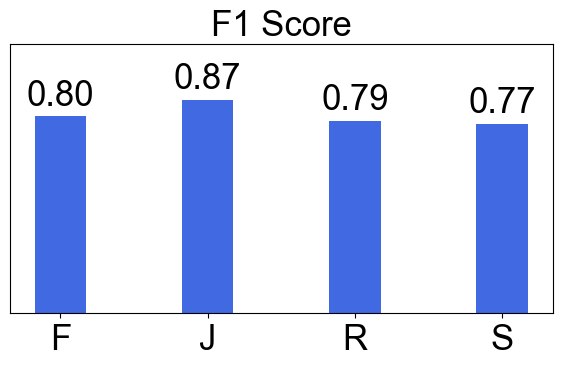

In [89]:
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=25
fig, ax = plt.subplots(figsize=(7, 3.5))
classes = ['F', 'J', 'R', 'S']
bar_width = 0.35
index = np.arange(len(classes))

# 绘制条形图
# rects1 = ax.bar(index, precision_4fold_mean, bar_width, label='Precision')
rects2 = ax.bar(index + 0.5*bar_width, f1_1s_mean, bar_width, label='F1 Score', color='#4169E1')

# 设置子图标签和标题
# inset_ax.set_xlabel('Class')
# inset_ax.set_ylabel('Scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classes, fontsize=25)
ax.set_yticklabels(ax.get_yticks(), fontsize=25) 
ax.set_title('F1 Score', fontsize=25)

# 调整子图y轴范围以容纳所有标签
ax.set_ylim(0, 1.1)

# 添加精确值标签
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom',fontsize=25)

# add_labels(rects1)
add_labels(rects2)

# 获取子图图例句柄和标签
sub_handles, sub_labels =ax.get_legend_handles_labels()
ax.legend().remove() 
ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
ax.yaxis.set_ticklabels([])      # 隐藏 y 轴标签

plt.savefig('1sf1score.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_22850/4129155093.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=25)


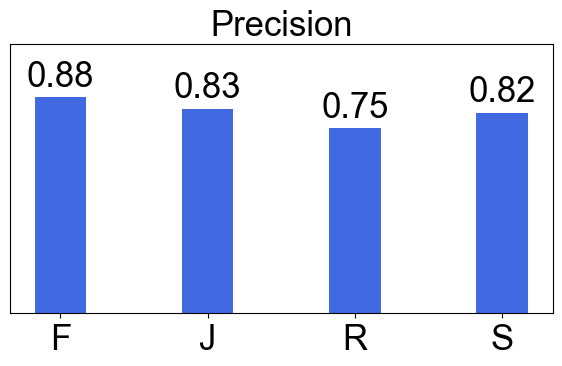

In [90]:
plt.rcParams['font.family']='arial'
plt.rcParams['font.size']=25
fig, ax = plt.subplots(figsize=(7, 3.5))
classes = ['F', 'J', 'R', 'S']
bar_width = 0.35
index = np.arange(len(classes))

# 绘制条形图
# rects1 = ax.bar(index, precision_4fold_mean, bar_width, label='Precision')
rects2 = ax.bar(index + 0.5*bar_width, precision_1s_mean, bar_width, label='Precision', color='#4169E1')

# 设置子图标签和标题
# inset_ax.set_xlabel('Class')
# inset_ax.set_ylabel('Scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classes, fontsize=25)
ax.set_yticklabels(ax.get_yticks(), fontsize=25) 
ax.set_title('Precision', fontsize=25)

# 调整子图y轴范围以容纳所有标签
ax.set_ylim(0, 1.1)

# 添加精确值标签
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom',fontsize=25)

# add_labels(rects1)
add_labels(rects2)

# 获取子图图例句柄和标签
sub_handles, sub_labels =ax.get_legend_handles_labels()
ax.legend().remove() 
ax.yaxis.set_ticks([])           # 隐藏 y 轴刻度
ax.yaxis.set_ticklabels([])      # 隐藏 y 轴标签

plt.savefig('1sprecision.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

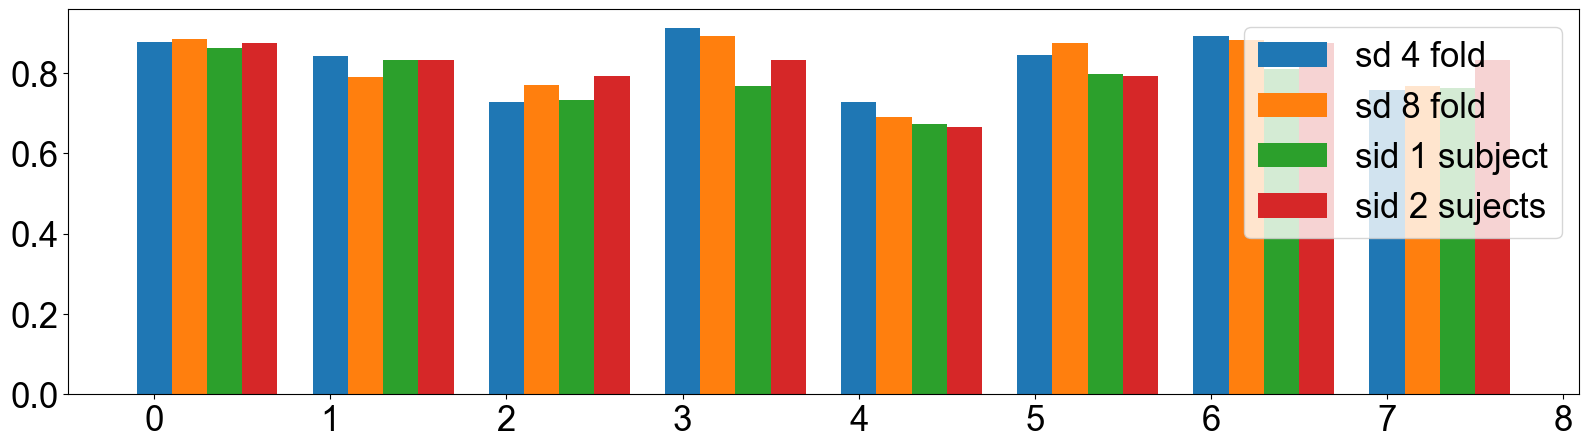

In [91]:
acc = np.column_stack((acc_sd_sb_4fold, acc_sd_sb_8fold, acc_2s, acc_1s))
x = np.arange(acc.shape[0])
bar_width = 0.2
fig, ax = plt.subplots(figsize=(19.5, 5))
ax.bar(x, acc[:, 0], bar_width, label='sd 4 fold')
ax.bar(x+bar_width, acc[:, 1], bar_width, label='sd 8 fold')
ax.bar(x+2*bar_width, acc[:, 2], bar_width, label='sid 1 subject')
ax.bar(x+3*bar_width, acc[:, 3], bar_width, label='sid 2 sujects')
ax.legend()

In [92]:
from brokenaxes import brokenaxes

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_22850/1750301596.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ylgnbu_cmap = cm.get_cmap('YlGnBu')


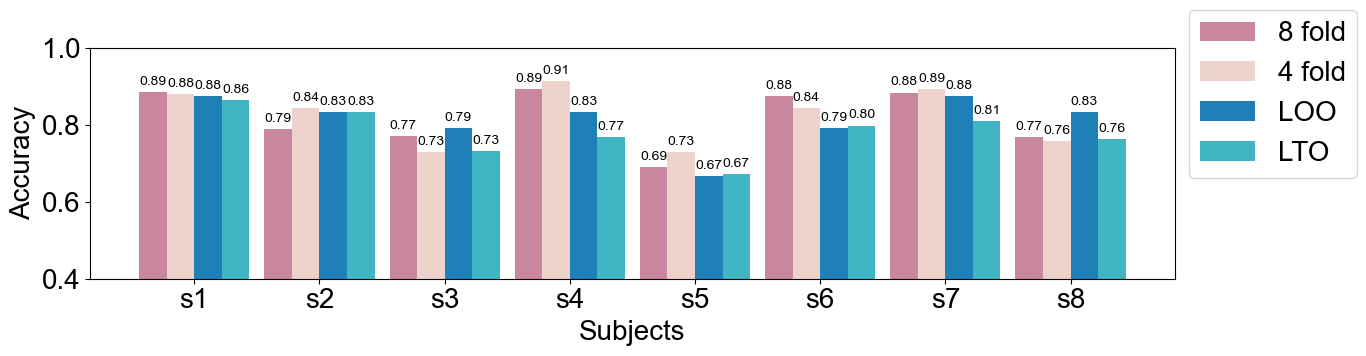

In [93]:
from matplotlib import cm
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 20
acc = np.column_stack((acc_sd_sb_8fold, acc_sd_sb_4fold, acc_1s, acc_2s))
x = np.arange(acc.shape[0])
bar_width = 0.22

fig, ax = plt.subplots(figsize=(14, 3))
# 从 Seaborn 的 cubehelix colormap 中获取颜色
cubehelix_cmap = sns.cubehelix_palette(as_cmap=True)
cubehelix_colors = [cubehelix_cmap(i) for i in np.linspace(0, 1, 4)[:2]]  # 取前两个颜色

# 从 "YlGnBu" colormap 中获取颜色
ylgnbu_cmap = cm.get_cmap('YlGnBu')
ylgnbu_colors = [ylgnbu_cmap(i) for i in np.linspace(0.5, 1, 4)[:2]]  # 取中间到尾部的两个颜色

# 将颜色合并
colors = cubehelix_colors + ylgnbu_colors

# 绘制柱状图
bars1 = ax.bar(x, acc[:, 0], bar_width, label='8 fold', color=colors[1])
bars2 = ax.bar(x + bar_width, acc[:, 1], bar_width, label='4 fold', color=colors[0])
bars3 = ax.bar(x + 2*bar_width, acc[:, 2], bar_width, label='LOO', color=colors[3])
bars4 = ax.bar(x + 3*bar_width, acc[:, 3], bar_width, label='LTO', color=colors[2])

# 为每个柱形添加精确值
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)
autolabel(bars4)

ax.set_xlabel('Subjects')
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1.05])
# ax.set_title('Accuracy by different settings')
ax.set_xticks(x + 1.5*bar_width)
ax.set_xticklabels(['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
ax.set_ylim([0.4, 1.0])
plt.savefig('bar_chart_with_legend.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

/var/folders/q9/tj643ymn6kv36f2m8db655540000gn/T/ipykernel_22850/1505369308.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ylgnbu_cmap = cm.get_cmap('YlGnBu')


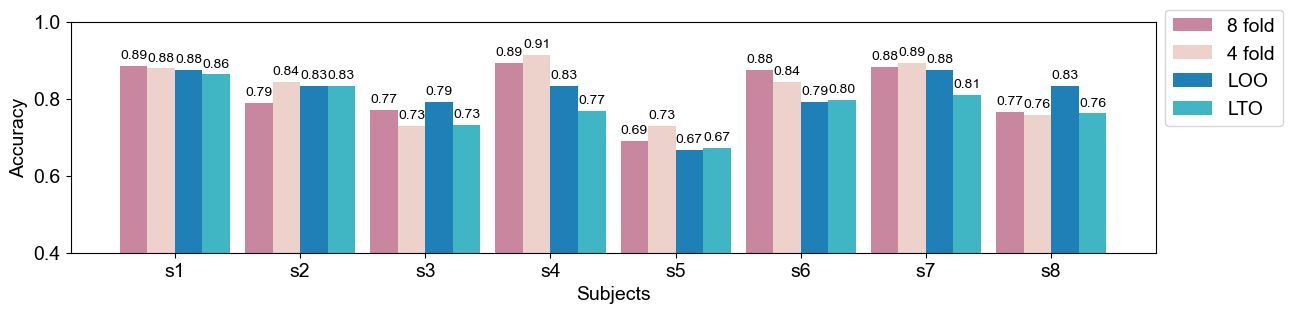

In [94]:
from matplotlib import cm
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 14
acc = np.column_stack((acc_sd_sb_8fold, acc_sd_sb_4fold, acc_1s, acc_2s))
x = np.arange(acc.shape[0])
bar_width = 0.22

fig, ax = plt.subplots(figsize=(14, 3))
# 从 Seaborn 的 cubehelix colormap 中获取颜色
cubehelix_cmap = sns.cubehelix_palette(as_cmap=True)
cubehelix_colors = [cubehelix_cmap(i) for i in np.linspace(0, 1, 4)[:2]]  # 取前两个颜色

# 从 "YlGnBu" colormap 中获取颜色
ylgnbu_cmap = cm.get_cmap('YlGnBu')
ylgnbu_colors = [ylgnbu_cmap(i) for i in np.linspace(0.5, 1, 4)[:2]]  # 取中间到尾部的两个颜色

# 将颜色合并
colors = cubehelix_colors + ylgnbu_colors

# 绘制柱状图
bars1 = ax.bar(x, acc[:, 0], bar_width, label='8 fold', color=colors[1])
bars2 = ax.bar(x + bar_width, acc[:, 1], bar_width, label='4 fold', color=colors[0])
bars3 = ax.bar(x + 2*bar_width, acc[:, 2], bar_width, label='LOO', color=colors[3])
bars4 = ax.bar(x + 3*bar_width, acc[:, 3], bar_width, label='LTO', color=colors[2])

# 为每个柱形添加精确值
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)
autolabel(bars4)

ax.set_xlabel('Subjects')
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1.05])
# ax.set_title('Accuracy by different settings')
ax.set_xticks(x + 1.5*bar_width)
ax.set_xticklabels(['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
ax.set_ylim([0.4, 1.0])
plt.savefig('bar_chart_with_legend.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()